# Imports

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

# Dataset

Link to dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=test.csv

In [5]:
df = pd.read_csv('/Users/anilthapa/Downloads/house-prices-advanced-regression-techniques/train.csv')

In [16]:
df.shape

(1460, 80)

# Preprocessing on the Dataset

In [13]:
df.drop('Id',axis = 1,  inplace=True)

In [23]:
df_nums = df.select_dtypes(include=['number']).columns
df_cats = df.select_dtypes(exclude=['number']).columns

In [28]:
imputer = SimpleImputer(strategy='median')

In [29]:
df[df_nums] = imputer.fit_transform(df[df_nums])

In [33]:
cats_imputer = SimpleImputer(strategy='most_frequent')

In [34]:
df[df_cats] = cats_imputer.fit_transform(df[df_cats])

In [36]:
X = df.drop('SalePrice', axis = 1)
y = df['SalePrice']

# Train the XGBoost Regressor

In [39]:
params = {
    'learning_rate': 0.1,
    'max_depth': 6, 
    'n_estimators': 100,
    'subsample':0.7,
}

In [41]:
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    params = params,
    early_stopping_rounds = 20
)

In [42]:
xgb_reg.fit(X, y)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:MSZoning: object, Street: object, Alley: object, LotShape: object, LandContour: object, Utilities: object, LotConfig: object, LandSlope: object, Neighborhood: object, Condition1: object, Condition2: object, BldgType: object, HouseStyle: object, RoofStyle: object, RoofMatl: object, Exterior1st: object, Exterior2nd: object, MasVnrType: object, ExterQual: object, ExterCond: object, Foundation: object, BsmtQual: object, BsmtCond: object, BsmtExposure: object, BsmtFinType1: object, BsmtFinType2: object, Heating: object, HeatingQC: object, CentralAir: object, Electrical: object, KitchenQual: object, Functional: object, FireplaceQu: object, GarageType: object, GarageFinish: object, GarageQual: object, GarageCond: object, PavedDrive: object, PoolQC: object, Fence: object, MiscFeature: object, SaleType: object, SaleCondition: object

RMSE: 0.4467
R² Score: 0.8477
Cross-Validation RMSE: 0.4542


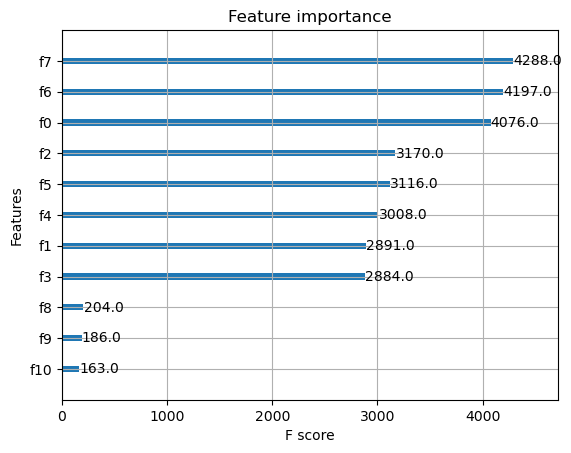

In [43]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing

# Load dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target  # Target variable

# Simulate categorical column (since California housing has only numerical)
df['HousingType'] = np.random.choice(['Apt', 'House', 'Condo'], size=len(df))

# Split data
X = df.drop(columns=['Target'])
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
num_features = X.select_dtypes(include=['number']).columns
cat_features = X.select_dtypes(exclude=['number']).columns

# Column transformer for preprocessing
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
        ('scaler', StandardScaler())  # Standardize numeric features
    ]), num_features),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
    ]), cat_features)
])

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Create a pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Cross-validation score
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross-Validation RMSE: {-np.mean(cv_scores):.4f}")

# Feature Importance
xgb_model.fit(preprocessor.fit_transform(X_train), y_train)  # Train XGBoost separately to extract feature importances
xgb.plot_importance(xgb_model)
plt.show()
